# Original procedure

The original procedure consists from the following steps:

1. Constructing reference from bulk methylation dataset;
2. Intersection of sites from sc-methylation data with presented in the reference dataset;
3. Filtering the sites with good correlation between methylation and age;
4. Getting probabilities of each site to be methylated;
5. Truncating probabilites if needed;
6. Estimation maximum likelihood function for different values of ages (where ages are chosen from the uniform grid);
7. Finding the age value maximizing log-likelihood.

![](figures/procedure.png)

# Problems with the procedure

## explore original procedure

In [61]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd

In [281]:
#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)

#get top n from them based on the absolute value of correlation
top = 10
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])
roots_ = -b_ / w_ #polynomial roots before single cell data

# make an artificial signle cell methylation data (sampled from binomial distribution)
p_nonmet = 0.5
mask = np.random.binomial(1, p=p_nonmet, size=top).astype(bool)

#change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
roots = -b / w #polynomial roots after single cell data

print('Correlation weights and biases before data', np.round(np.corrcoef(w_, b_)[0,1], 3))
print('Correlation weights and biases after data', np.round(np.corrcoef(w, b)[0,1], 3))

Correlation weights and biases before data -0.867
Correlation weights and biases after data -0.485


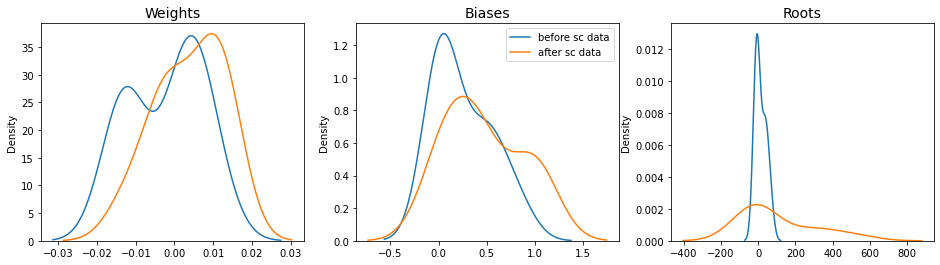

In [282]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('Weights', fontsize=14)
sns.kdeplot(w_, label='before sc data', ax=axes[0])
sns.kdeplot(w, label='after sc data', ax=axes[0])

axes[1].set_title('Biases', fontsize=14)
sns.kdeplot(b_, label='before sc data', ax=axes[1])
sns.kdeplot(b, label='after sc data', ax=axes[1])

axes[2].set_title('Roots', fontsize=14)
sns.kdeplot(roots_, label='before sc data', ax=axes[2])
sns.kdeplot(roots, label='after sc data', ax=axes[2])

axes[1].legend()
plt.show()

* if left boundary of site > right boundary of search interval, $p \approx 1$
* if right boundary of site < left boundary of search interval, $p \approx 0$

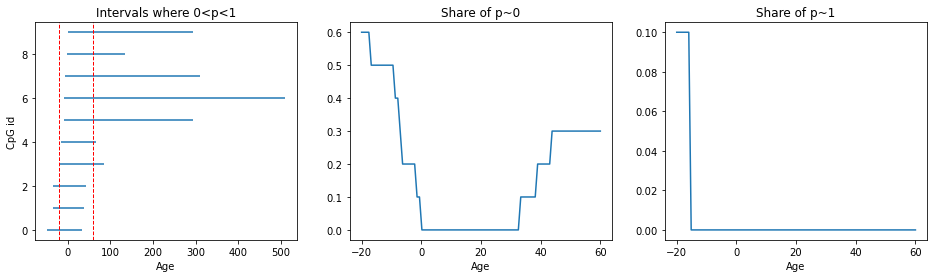

In [283]:
interval_of_search = (-20, 60)

x_intervals = np.array([[-bi/wi if -bi/wi < (1-bi)/wi else (1-bi)/wi for bi, wi in zip(b_, w_)], 
                        [(1-bi)/wi if -bi/wi < (1-bi)/wi else -bi/wi for bi, wi in zip(b_, w_)],]).T
sorted_intervals = x_intervals[np.argsort(x_intervals[:, 0])]

x = np.linspace(interval_of_search[0], interval_of_search[1], 100)
share_of_p0 = []
share_of_p1 = []
for xi in x:
    p = w_ * xi + b_
    share_of_p0.append((p < 0).sum() / p.shape[0])
    share_of_p1.append((p > 1).sum() / p.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, (xmin, xmax) in enumerate(sorted_intervals):
    axes[0].hlines(i, xmin, xmax)
axes[0].axvline(interval_of_search[0], lw=1, ls='--', color='red')
axes[0].axvline(interval_of_search[1], lw=1, ls='--', color='red')
axes[0].set_title('Intervals where 0<p<1')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('CpG id');

axes[1].plot(x, share_of_p0)
axes[2].plot(x, share_of_p1)
axes[1].set_title('Share of p~0')
axes[2].set_title('Share of p~1')
axes[1].set_xlabel('Age')
axes[2].set_xlabel('Age');

In [303]:
n_steps = 100
m_cells = 100
#interval_of_search = (-20, 60)
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
one_met_replacement = 0.999
zero_met_replacement = 0.001

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

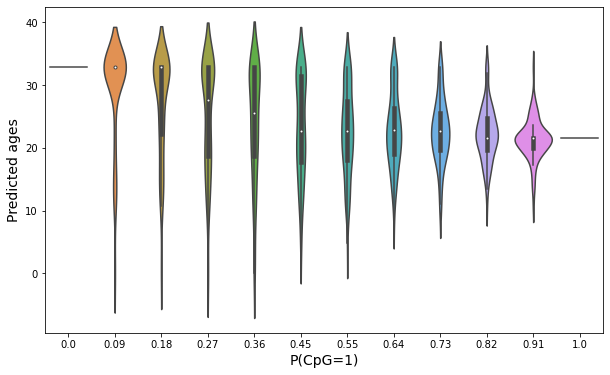

In [304]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

## correct procedure

In [301]:
from scipy.optimize import fsolve
import numpy as np

def get_max(w, b, domain=None, verbose=0):
    """
    docs
    """
    roots = -b / w
    ord = 'even' if (len(roots) % 2) == 0 else 'odd'
    sign = np.prod(np.sign(w))
    roots = np.sort(roots)
    domain = [roots[0], roots[-1]] if domain is None else domain

    ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
    logf = lambda x: sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
    df = lambda x: sum([wi/(wi*x + bi) for wi, bi in zip(w, b)])

    if (ord == 'even') and (sign > 0): #first root left from min; last root right from min
        pairs = roots[1:-1].reshape(-1, 2).tolist()
    elif (ord == 'even') and (sign < 0): #first root left from max; last root right from max
        pairs = roots.reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign > 0): #first root left from max; last root right from min
        pairs = roots[:-1].reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign < 0): #first root left from min; last root right from max
        pairs = roots[1:].reshape(-1, 2).tolist()

    maxroots = []
    for pair in pairs:
        if (pair[0] >= domain[0]) and (pair[1] <= domain[1]):
            root = fsolve(df, np.mean(pair))[0]
        else:
            continue
        maxroots.append(root)
    
    maxroots = [domain[0]] + maxroots + [domain[1]]
    solution = maxroots[np.argmax([ff(m) for m in maxroots])]
    if verbose > 0:
        if (solution == maxroots[0]):
            print('Solution on the start of the interval!')
        elif solution == maxroots[-1]:
            print('Solution on the end of the interval!')
        else:
            pass
    return solution

In [302]:
m_cells = 100

eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print("Correct interval:", interval_of_search)

data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    x_opt = np.zeros(m_cells)
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        w = np.where(mask, w_, -w_)
        b = np.where(mask, w_, 1-b_)
        x_opt[cell] = get_max(w, b, domain=interval_of_search, verbose=0)

    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

Correct interval: (0.14468047317651128, 32.896220489182774)


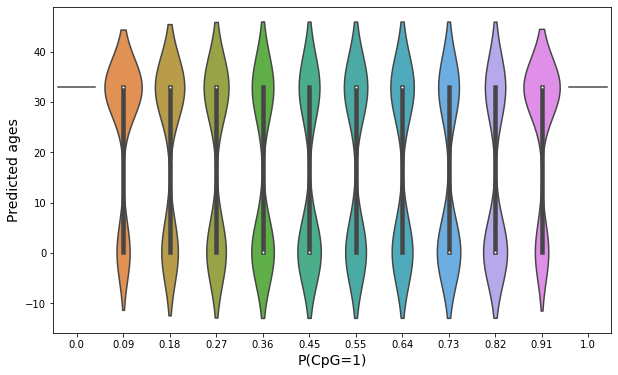

In [299]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

In [300]:
# from scipy.signal import argrelextrema

# # n = 20 #number of weights
# # w = np.random.randn(n)  # w \in R
# # b = np.random.randn(n)  # b > 0
# roots = -b / w

# ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
# z = np.linspace(-100, 100, 1000)
# fz = [ff(zi) for zi in z]

# num_max = z[argrelextrema(np.array(fz), np.greater)[0]\
#     [np.argmax(np.array(fz)[argrelextrema(np.array(fz), np.greater)[0]])]]
# num_max = [z[0], num_max, z[-1]][np.argmax([ff(z[0]), ff(num_max), ff(z[-1])])]

# print(get_max(w, b, domain=[-100, 100]))
# print(num_max)

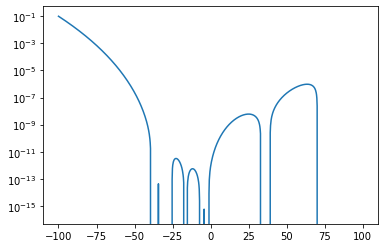

In [123]:
plt.semilogy(z, fz)

In [102]:
ff(40)

1.939348952221965e+28

In [29]:
roots[roots < 0].max()

-0.13985594640319554

In [64]:

[np.sum(np.log(w * x + b)) for x in [0, 0, 1, 2]]


/tmp/ipykernel_165710/255176223.py:1: RuntimeWarning: invalid value encountered in log
  [np.sum(np.log(w * x + b)) for x in [0, 0, 1, 2]]


[-21.887620007983323, -21.887620007983323, nan, nan]

In [19]:
roots

array([ 0.82265991,  0.06802142,  0.81699687,  0.53951353,  0.14787981,
       -0.13985595,  3.35213427, -0.30329181,  0.28370819,  0.83891022])

In [662]:
print(get_max(w, b, domain=[-100, 100]))

5.293691805412653


In [664]:
w_ = w

In [670]:
w_[:20] = w_[:20]/1000

In [673]:
print(get_max(w, b, domain=[-100, 100]))

-3.281438984558798


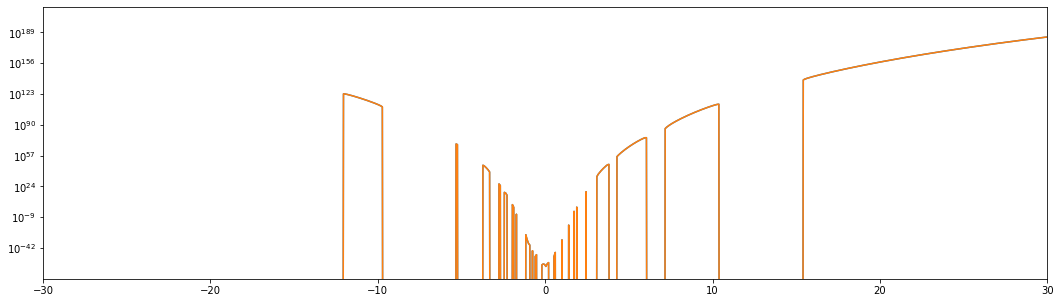

In [647]:
plt.figure(figsize=(18,5))
plt.semilogy(z, fz)
plt.plot(z, fz)
plt.xlim([-30, 30])
plt.eventplot(roots, color='red', lw=2)

In [3]:
x = np.linspace(1, 1000, 1000)
y = np.linspace(1, 5, 1000)

In [25]:
x = [1, 1.9, 2.1, 4]
y = [-1, 10, 10, 20]

n = len(x)
r, p  = spearmanr(age, y)
s2 = (1 + r**2/2) / (n - 3)
t = r * np.sqrt((n-2) / (1 - r**2))
r, p, t, s2 

(0.9486832980505139,
 0.051316701949486114,
 1.4500000000000002,
 4.242640687119288)

In [30]:
tstat.pdf(t, n-1)

0.007501073407099191

SpearmanrResult(correlation=1.0, pvalue=0.0)


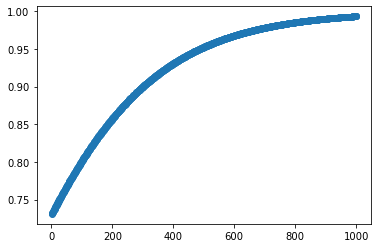

In [35]:
#fy = 1 / (1 + np.exp(-y))
fy = logistic.cdf(y)
print(spearmanr(x, fy))
plt.scatter(x, fy)